In [5]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator
import stimcirq
from qiskit.visualization import plot_histogram
from encoded.dj import dj, dj_steane, dj_tcc
from encoded.tcc import tcc_encoding
from encoded.LST import int_to_binary
import matplotlib.pyplot as plt

## Computer parameters

In [ ]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation
layout = {
    1 : [63, 64],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85]
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

## Oracle definition

In [ ]:
total_qubits = 2
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))

# Fixed case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
oracleType,oracleValue

(1, 1)

# Full connectivity

### Analog

In [4]:
n_shots = 600_000
noise = cirq.depolarize
noise_set = np.logspace(-3,-1,10)
infidelity_analog = []
for noise_ratio in noise_set:
    qreg = cirq.LineQubit.range(total_qubits)
    circuit = dj(qreg,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    # if oracleType==1:
    infidelity_analog.append(1-counts[int(int_to_binary(total_qubits-1,oracleValue))]/n_shots)
    # else:
    #     infidelity_analog.append(1-counts[int("0"*(total_qubits-1))]/n_shots)

### Encoded

In [6]:
def codewords_tcc(n_encoding,distance):
    circuit = tcc_encoding(distance)
    qreg = cirq.LineQubit.range(n_encoding)
    circuit.append(cirq.measure(qreg, key="m"))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    logical_0 = [format(key, '0'+str(n_encoding)+'b') for key in counts.keys()]
    logical_1 = [s.replace('1', '2').replace('0', '1').replace('2', '0') for s in logical_0]
    return logical_0, logical_1

In [8]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1


k = 2
distance = 3
n_encoding =7

logical_0_codeword,logical_1_codeword = codewords_tcc(n_encoding,distance)
qreg = cirq.LineQubit.range(n_encoding*k)
infidelity_encoded = []
for noise_ratio in noise_set:
    circuit= dj_tcc(qreg,distance,n_encoding,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    counts_logical_1 = 0
    for e in logical_1_codeword:
        counts_logical_1 += counts[int(e,2)]
    counts_logical_0 = 0
    for e in logical_0_codeword:
        counts_logical_0 += counts[int(e,2)]

    if oracleType==1 and oracleValue ==1:
        infidelity_encoded.append(1-counts_logical_1/(counts_logical_1+counts_logical_0))
    else:
        infidelity_encoded.append(1-counts_logical_0/(counts_logical_1+counts_logical_0))



In [9]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1


k = 2
distance = 5
n_encoding = 19

logical_0_codeword,logical_1_codeword = codewords_tcc(n_encoding,distance)
qreg = cirq.LineQubit.range(n_encoding*k)
infidelity_encoded_d5 = []
for noise_ratio in noise_set:
    circuit= dj_tcc(qreg,distance,n_encoding,oracleType,oracleValue)
    circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
    circuit = circuit.with_noise(noise(noise_ratio))
    simulator = stimcirq.StimSampler()
    counts = simulator.run(circuit, repetitions=n_shots).histogram(key="m")
    counts_logical_1 = 0
    for e in logical_1_codeword:
        counts_logical_1 += counts[int(e,2)]
    counts_logical_0 = 0
    for e in logical_0_codeword:
        counts_logical_0 += counts[int(e,2)]

    if oracleType==1 and oracleValue ==1:
        infidelity_encoded_d5.append(1-counts_logical_1/(counts_logical_1+counts_logical_0))
    else:
        infidelity_encoded.append(1-counts_logical_0/(counts_logical_1+counts_logical_0))



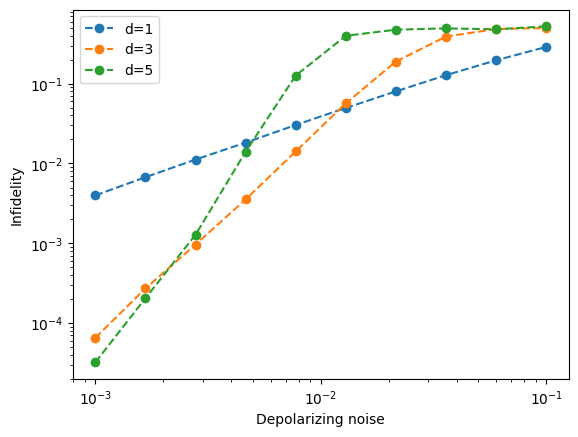

In [10]:
plt.figure()
plt.loglog(noise_set,infidelity_analog,"--o",label = "d=1")
plt.loglog(noise_set,infidelity_encoded,"--o",label = "d=3")
plt.loglog(noise_set,infidelity_encoded_d5,"--o",label = "d=5")


# plt.ylim(1e-4,5e-1)
plt.xlabel("Depolarizing noise")
plt.ylabel("Infidelity")
plt.legend()


## Measuring the observable $<Z>$

In [16]:
from typing import Dict, List
from mitiq import PauliString
import functools
import itertools

from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit, get_paulis_from_stabilizer_matrix


def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

def measure_observable(
    pauli: cirq.PauliString,
    bitstring: str,
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    indices = [q.x for q in pauli.qubits]
    bitstring = list(map(int, list(bitstring[::-1])))
    return (-1) ** sum([bitstring[i] for i in indices])



def get_lst_ev(counts, observables, stabilizers):
    k = len(list(counts)[0]) // n
    nshots = sum(counts.values())

    numerator = 0
    for bitstring, count in counts.items():
        m = 1
        for i in range(k):
            qubit_ev = 0
            for ob in observables:
                qubit_ev += measure_observable(ob, bitstring[i*n : (i+1)*n]) / len(observables)
            m *= qubit_ev
        numerator += m * count / nshots

    denominator = 0
    for bitstring, count in counts.items():
        m = 1
        for i in range(k):
            qubit_ev = 0
            for stab in stabilizers:
                qubit_ev += measure_observable(stab, bitstring[i*n : (i+1)*n]) / len(stabilizers)
            m *= qubit_ev
        denominator += m * count / nshots
        
    return float(np.real_if_close(numerator / denominator))

In [17]:

qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
print(circuit)
compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  # Hardcode n = 1 (i.e., no encoding) to get layout.
    routing_method="sabre",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()
ev = compute_expectation(PauliString("Z")._pauli, counts)
print(ev)

       ┌───┐          ┌───┐┌─┐
  q_0: ┤ H ├───────■──┤ H ├┤M├
       ├───┤┌───┐┌─┴─┐└───┘└╥┘
  q_1: ┤ X ├┤ H ├┤ X ├──────╫─
       └───┘└───┘└───┘      ║ 
m_m: 1/═════════════════════╩═
                            0 
-0.9764633333333333


In [18]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
k = 2
n = 7
qreg = cirq.LineQubit.range(n*k)
circuit= dj_steane(qreg,oracleType,oracleValue)


generator_strs = [
    "XXXXIII",
    "IXXIXXI",
    "IIXXIXX",
    "ZZZZIII",
    "IZZIZZI",
    "IIZZIZZ"
]

observable = PauliString("Z" * n)._pauli
stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg[:n])
m_circuit, transformed_matrix = get_measurement_circuit(stabilizer_matrix)
measurement_circuit = m_circuit

transformed_generators = get_paulis_from_stabilizer_matrix(transformed_matrix)
# print(transformed_generators)
stabilizer_elements = generate_stabilizer_elements(transformed_generators)

transformed_observable = observable.conjugated_by(m_circuit**-1)
observable_elements = [transformed_observable * stab for stab in stabilizer_elements]

circuit+= measurement_circuit
circuit.append(cirq.measure(qreg[:n*(k-1)], key="m"))
circ_full = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled = qiskit.transpile(
    circ_full, 
    backend=computer,
    initial_layout=layout[n],
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

compiled.draw(fold=-1, idle_wires=False)
compiled.count_ops()

OrderedDict([('rz', 615),
             ('sx', 353),
             ('ecr', 192),
             ('x', 17),
             ('reset', 14),
             ('measure', 7)])

In [ ]:
job = computer.run(
    compiled,
    shots=n_shots,
)

counts = job.result().get_counts()

In [ ]:
ev = get_lst_ev(counts, observable_elements, stabilizer_elements)
print(ev)

-0.7002491280518187


# Transpiled

## Analog version

In [51]:


n_shots = 500_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()


In [52]:
compiled_raw.draw(fold = -1)

global phase: 5π/4
                                                                                                                                                              
    ancilla_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_1 -> 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_2 -> 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_3 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_4 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_5 -> 5 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_6 -> 6 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_7 -> 7 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_8 -> 8 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
    ancilla_9 -> 9 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
  ancilla_10 -> 10 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
  ancilla_11 -> 11 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                              
  anci

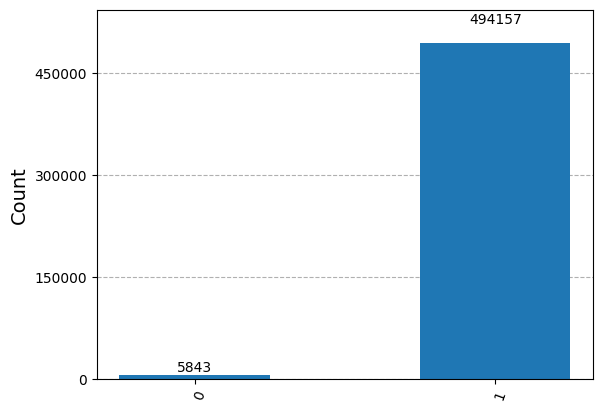

In [53]:
threshold = int(0.001 * n_shots) 
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold}
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [54]:
if oracleType==1:
    print("Total fidelity F = ",counts[int_to_binary(total_qubits-1,oracleValue)]/n_shots*100,"%")
else:
    print("Total fidelity F = ",counts["0"*(total_qubits-1)]/n_shots*100,"%")

Total fidelity F =  98.8314 %


## Encoding the Steane code (k = 2)

In [ ]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1

# Steane codewords (you can get them by simulating the dj_steane without noise)
logical_1_codeword = ["1110000","0101010","1000110","0100101","0010011","1001001","1111111","0011100"]
logical_0_codeword = ["1011010","0001111","0000000","0110110","1101100","1010101","0111001","1100011"]


k = 2
qreg = cirq.LineQubit.range(7*k)
circuit= dj_steane(qreg,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:7*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


OrderedDict([('rz', 408),
             ('sx', 229),
             ('ecr', 129),
             ('reset', 14),
             ('x', 14),
             ('measure', 7)])

In [62]:
circuit.draw(fold = -1)

┌───┐            ┌───┐                               ┌───┐                         ┌─┐                            
  q_0: ─|0>─┤ H ├─■──■─────■─┤ H ├────────────────────────────■──┤ H ├─────────────────────────┤M├────────────────────────────
            ├───┤ │  │     │ └───┘        ┌───┐               │  └───┘     ┌───┐               └╥┘     ┌─┐                    
  q_1: ─|0>─┤ H ├─┼──┼──■──┼───■────────■─┤ H ├───────────────┼─────────■──┤ H ├────────────────╫──────┤M├────────────────────
            ├───┤ │  │  │  │   │        │ └───┘        ┌───┐  │         │  └───┘          ┌───┐ ║      └╥┘           ┌─┐      
  q_2: ─|0>─┤ H ├─┼──┼──┼──┼───┼────■───┼───■────────■─┤ H ├──┼─────────┼──────────────■──┤ H ├─╫───────╫────────────┤M├──────
            ├───┤ │  │  │  │   │    │   │   │  ┌───┐ │ ├───┤  │         │       ┌───┐  │  └───┘ ║       ║ ┌─┐        └╥┘      
  q_3: ─|0>─┤ H ├─■──┼──■──┼───┼────■───┼───┼──┤ H ├─┼─┤ H ├──┼─────────┼────■──┤ H ├──┼────────╫───────╫─┤M├─────────╫───────
            ├───┤    │     │   │  ┌───┐ │   │  ├───┤ │ └───┘  │         │    │  └───┘  │  ┌───┐ ║       ║ └╥┘┌─┐      ║       
  q_4: ─|0>─┤ H ├────■─────┼───■──┤ H ├─┼───┼──┤ H ├─┼────────┼─────────┼────┼────■────┼──┤ H ├─╫───────╫──╫─┤M├──────╫───────
            ├───┤          │      └───┘ │   │  ├───┤ │ ┌───┐  │         │    │    │    │  └───┘ ║ ┌───┐ ║  ║ └╥┘      ║ ┌─┐   
  q_5: ─|0>─┤ H ├──────────■────────────┼───■──┤ H ├─┼─┤ H ├──┼─────────┼────┼────┼────┼────■───╫─┤ H ├─╫──╫──╫───────╫─┤M├───
            ├───┤                       │      └───┘ │ ├───┤  │  ┌───┐  │    │    │    │    │   ║ └───┘ ║  ║  ║ ┌───┐ ║ └╥┘┌─┐
  q_6: ─|0>─┤ H ├───────────────────────■────────────■─┤ H ├──┼──┤ H ├──┼────┼────┼────┼────┼───╫───■───╫──╫──╫─┤ H ├─╫──╫─┤M├
            ├───┤            ┌───┐┌───┐                └───┘┌─┴─┐└───┘  │    │    │    │    │   ║   │   ║  ║  ║ └───┘ ║  ║ └╥┘
  q_7: ─|0>─┤ H ├─■──■─────■─┤ X ├┤ H ├─────────────────────┤ X ├───────┼────┼────┼────┼────┼───╫───┼───╫──╫──╫───────╫──╫──╫─
            ├───┤ │  │     │ └───┘└───┘   ┌───┐┌───┐        └───┘     ┌─┴─┐  │    │    │    │   ║   │   ║  ║  ║       ║  ║  ║ 
  q_8: ─|0>─┤ H ├─┼──┼──■──┼───■────────■─┤ X ├┤ H ├──────────────────┤ X ├──┼────┼────┼────┼───╫───┼───╫──╫──╫───────╫──╫──╫─
            ├───┤ │  │  │  │   │        │ └───┘└───┘   ┌───┐┌───┐     └───┘  │    │  ┌─┴─┐  │   ║   │   ║  ║  ║       ║  ║  ║ 
  q_9: ─|0>─┤ H ├─┼──┼──┼──┼───┼────■───┼───■────────■─┤ X ├┤ H ├────────────┼────┼──┤ X ├──┼───╫───┼───╫──╫──╫───────╫──╫──╫─
            ├───┤ │  │  │  │   │    │   │   │  ┌───┐ │ ├───┤├───┤          ┌─┴─┐  │  └───┘  │   ║   │   ║  ║  ║       ║  ║  ║ 
 q_10: ─|0>─┤ H ├─■──┼──■──┼───┼────■───┼───┼──┤ H ├─┼─┤ X ├┤ H ├──────────┤ X ├──┼─────────┼───╫───┼───╫──╫──╫───────╫──╫──╫─
            ├───┤    │     │   │  ┌───┐ │   │  ├───┤ │ ├───┤└───┘          └───┘┌─┴─┐       │   ║   │   ║  ║  ║       ║  ║  ║ 
 q_11: ─|0>─┤ H ├────■─────┼───■──┤ H ├─┼───┼──┤ X ├─┼─┤ H ├────────────────────┤ X ├───────┼───╫───┼───╫──╫──╫───────╫──╫──╫─
            ├───┤          │      └───┘ │   │  ├───┤ │ ├───┤┌───┐               └───┘     ┌─┴─┐ ║   │   ║  ║  ║       ║  ║  ║ 
 q_12: ─|0>─┤ H ├──────────■────────────┼───■──┤ H ├─┼─┤ X ├┤ H ├─────────────────────────┤ X ├─╫───┼───╫──╫──╫───────╫──╫──╫─
            ├───┤                       │      └───┘ │ ├───┤├───┤┌───┐                    └───┘ ║ ┌─┴─┐ ║  ║  ║       ║  ║  ║ 
 q_13: ─|0>─┤ H ├───────────────────────■────────────■─┤ H ├┤ X ├┤ H ├──────────────────────────╫─┤ X ├─╫──╫──╫───────╫──╫──╫─
            └───┘                                      └───┘└───┘└───┘                          ║ └───┘ ║  ║  ║       ║  ║  ║ 
m_m: 7/═════════════════════════════════════════════════════════════════════════════════════════╩═══════╩══╩══╩═══════╩══╩══╩═
                                                                                                0       1  3  4       2  5  6

In [64]:
job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

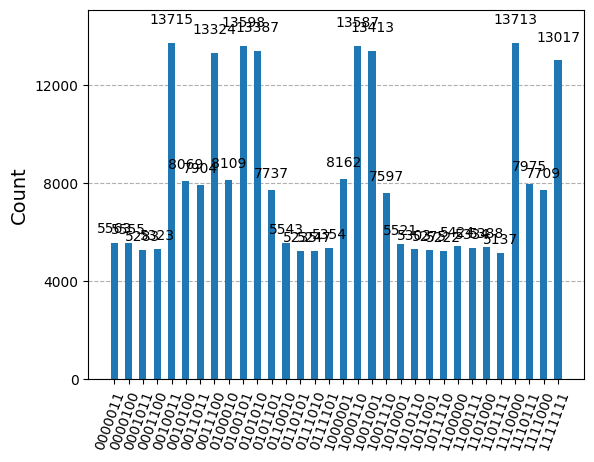

In [66]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

### Using the encoding to take into account only the logical errors

In [67]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  91.26049139091917 %
